# Assignment 1: NARMA10 task
## RNN

Note: as a reference for keras tuner I used the documentation: https://www.tensorflow.org/tutorials/keras/keras_tuner

In [41]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
import keras_tuner as kt

## Load the dataset

(1, 4000, 1)
(1, 4000, 1)
(1, 1000, 1)
(1, 1000, 1)
(1, 4990, 1)
(1, 4990, 1)


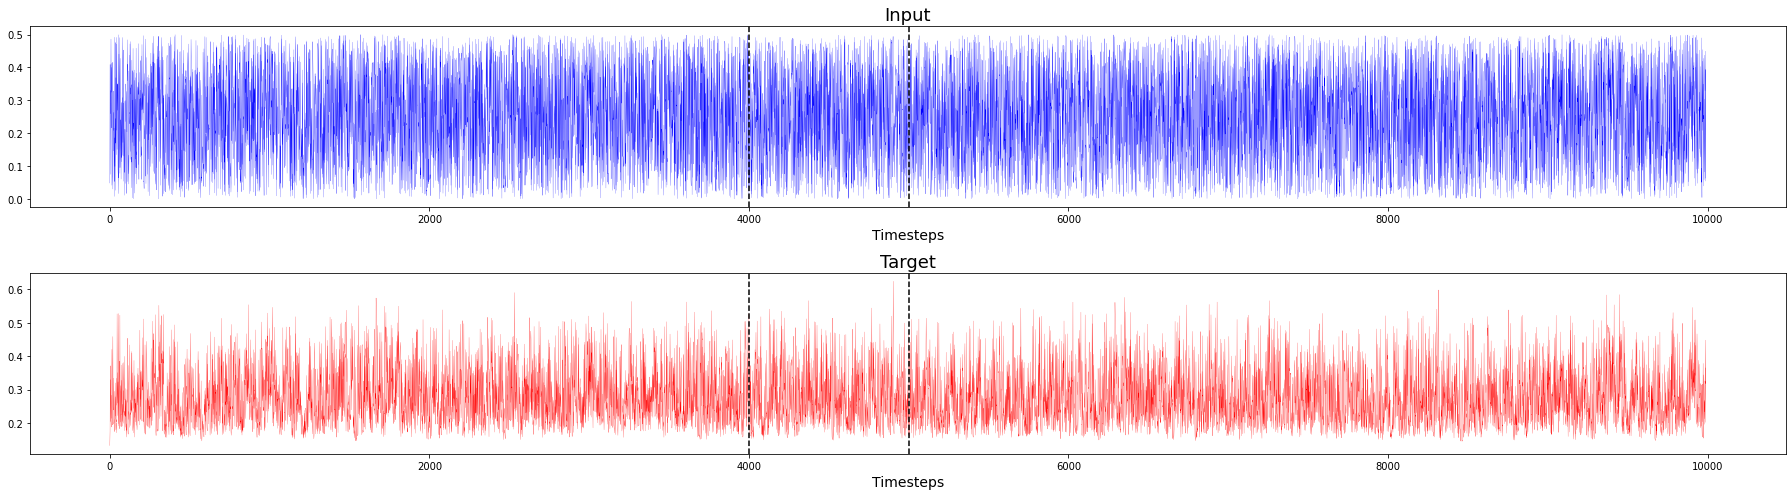

In [29]:
#load the data
x, y = np.loadtxt("NARMA10.csv", delimiter=",")

#remove first 10 timesteps besause y = 0
x = x[10:]
y = y[10:]

#split the dataset into training, validation and test
x_train = x[:4000]
x_valid = x[4000:5000]
x_test = x[5000:]

y_train = y[:4000]
y_valid = y[4000:5000]
y_test = y[5000:]

#plot the data
t=np.arange(start=0,stop=len(x), step=1)
plt.figure(figsize = (25,7))
ax1 = plt.subplot(211)
plt.title('Input', fontsize=18)
ax1.plot(t,x, color = 'b', linewidth= 0.2)
ax1.axvline(x = 4000, color = 'black', linestyle= '--')
ax1.axvline(x = 5000, color = 'black', linestyle= '--')
plt.xlabel('Timesteps', fontsize=14)


ax2 = plt.subplot(212, sharex = ax1)
plt.title('Target', fontsize=18)
ax2.plot(t,y, color = 'r', linewidth = 0.2)
ax2.axvline(x = 4000, color = 'black', linestyle= '--')
ax2.axvline(x = 5000, color = 'black', linestyle= '--')
plt.xlabel('Timesteps', fontsize=14)
plt.tight_layout()

#reshape the data to feed the RNN
X_train = np.reshape(x_train, (1,len(x_train),1))
Y_train = np.reshape(y_train, (1,len(y_train),1))

X_valid = np.reshape(x_valid, (1,len(x_valid),1))
Y_valid = np.reshape(y_valid, (1,len(y_valid),1))

X_test = np.reshape(x_test, (1,len(x_test),1))
Y_test = np.reshape(y_test, (1,len(y_test),1))

#check the shapes
print(X_train.shape)
print(Y_train.shape)

print(X_valid.shape)
print(Y_valid.shape)

print(X_test.shape)
print(Y_test.shape)


### Create the model
To do model selection, we actually create the "hypermodel", defining the hyperparameter search space as well as the architecture of the model.

In [17]:
def model_architecture(lr, hidden_units, activation_h, activation_d):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, activation=activation_h, return_sequences=True, stateful = True, batch_input_shape=(1,None,1))) 
    model.add(Dense(units=1, activation=activation_d))
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=lr),metrics=['mean_squared_error'])
    return model

def create_model(hp):
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 10-300
    hidden_units = hp.Int('units',  min_value=10, max_value=300, step=10)

    #Tune the activation function of the hidden layer
    activation_h = hp.Choice("activation_h", ["linear","relu", "tanh"])
    #Tune the activation function of the dense layer
    activation_d = hp.Choice("activation_d", ["linear","relu"])

    # Tune the learning rate for the optimizer
    lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # call model-building code with the hyperparameter values.
    model = model_architecture( hidden_units = hidden_units, activation_h = activation_h, activation_d = activation_d, lr=lr
    )
    return model

Instantiate hyperparameter tuner

In [18]:
# use random search to find optimal hyperparameters
tuner = kt.RandomSearch(
                     hypermodel =create_model,
                     objective='val_mean_squared_error',
                     max_trials=25,
                     overwrite=True,
                     directory='tuner',
                     project_name='tuner_rnn'
                     )

tuner.search_space_summary()

Create a callback to stop training early after reaching a certain value for the validation loss.

In [20]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

### Train the model

In [21]:
tuner.search(X_train, Y_train, epochs=100, validation_data = (X_valid, Y_valid))

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


print(f"""
Completed hyperparameters search.\n
Otimal number of units of hidden layer = {best_hps.get('units')} \n
Optimal learning rate for the optimizer = {best_hps.get('learning_rate')} \n
Optimal activation function for the hidden layer = {best_hps.get('activation_h')} \n
Optimal activation function for the dense layer = {best_hps.get('activation_d')}
""")


Trial 25 Complete [00h 01m 07s]
val_mean_squared_error: 0.08432170748710632

Best val_mean_squared_error So Far: 0.0009090182720683515
Total elapsed time: 00h 26m 53s
INFO:tensorflow:Oracle triggered exit

Completed hyperparameters search.

Otimal number of units of hidden layer = 170 

Optimal learning rate for the optimizer = 0.001 

Optimal activation function for the hidden layer = relu 

Optimal activation function for the dense layer = linear



Find the optimal number of epochs

In [22]:
# Build the model with the optimal hyperparameters and train it on the data for 300 epochs
model = tuner.hypermodel.build(best_hps)
model.summary()
history = model.fit(X_train, Y_train, epochs=500, verbose=2, validation_data = (X_valid, Y_valid))

Epoch 1/500
1/1 - 2s - loss: 0.0722 - mean_squared_error: 0.0722 - val_loss: 0.0489 - val_mean_squared_error: 0.0489 - 2s/epoch - 2s/step
Epoch 2/500
1/1 - 1s - loss: 0.0493 - mean_squared_error: 0.0493 - val_loss: 0.0315 - val_mean_squared_error: 0.0315 - 584ms/epoch - 584ms/step
Epoch 3/500
1/1 - 1s - loss: 0.0317 - mean_squared_error: 0.0317 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - 647ms/epoch - 647ms/step
Epoch 4/500
1/1 - 1s - loss: 0.0174 - mean_squared_error: 0.0174 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - 631ms/epoch - 631ms/step
Epoch 5/500
1/1 - 1s - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - 586ms/epoch - 586ms/step
Epoch 6/500
1/1 - 1s - loss: 0.0181 - mean_squared_error: 0.0181 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - 650ms/epoch - 650ms/step
Epoch 7/500
1/1 - 1s - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - 615ms/epoch - 615ms/ste

Find best epoch:

In [23]:
val_mse_per_epoch = history.history['val_mean_squared_error']
best_epoch = val_mse_per_epoch.index(min(val_mse_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 464


Re-instantiate the hypermodel and train it with the optimal number of epochs from above.

In [24]:
hypermodel = tuner.hypermodel.build(best_hps)
# Retrain the model
history = hypermodel.fit(X_train, Y_train, epochs=best_epoch, verbose=2, validation_data = (X_valid, Y_valid)).history

Epoch 1/464
1/1 - 2s - loss: 0.1011 - mean_squared_error: 0.1011 - val_loss: 0.0652 - val_mean_squared_error: 0.0652 - 2s/epoch - 2s/step
Epoch 2/464
1/1 - 1s - loss: 0.0661 - mean_squared_error: 0.0661 - val_loss: 0.0387 - val_mean_squared_error: 0.0387 - 649ms/epoch - 649ms/step
Epoch 3/464
1/1 - 1s - loss: 0.0393 - mean_squared_error: 0.0393 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - 531ms/epoch - 531ms/step
Epoch 4/464
1/1 - 1s - loss: 0.0186 - mean_squared_error: 0.0186 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - 623ms/epoch - 623ms/step
Epoch 5/464
1/1 - 1s - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0211 - val_mean_squared_error: 0.0211 - 629ms/epoch - 629ms/step
Epoch 6/464
1/1 - 1s - loss: 0.0212 - mean_squared_error: 0.0212 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - 644ms/epoch - 644ms/step
Epoch 7/464
1/1 - 1s - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0066 - val_mean_squared_error: 0.0066 - 617ms/epoch - 617ms/ste

### Make plots of the loss and validation loss

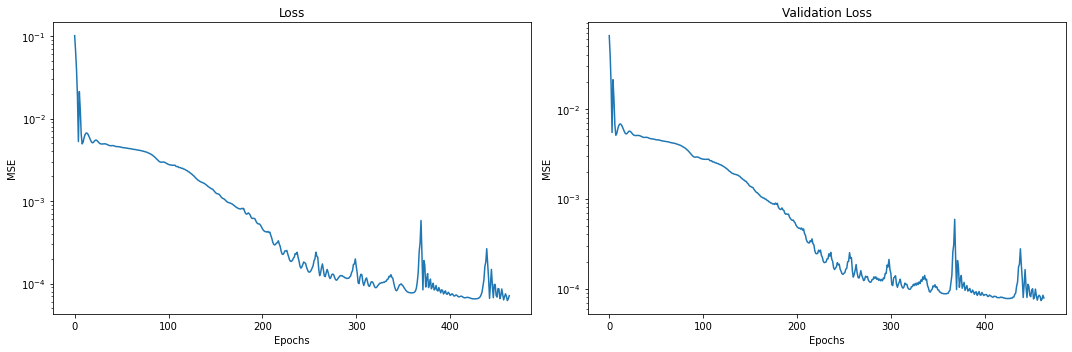

In [40]:
plt.figure(figsize = (15,5))
plt.subplot(121)
plt.title('Loss')
plt.plot(history['loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.yscale('log')

plt.subplot(122)
plt.title('Validation Loss')
plt.plot(history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.yscale('log')
plt.tight_layout()

plt.show()

Save the model

In [26]:
hypermodel.save('keras_model_rnn')

2023-05-05 14:50:18.740415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [1,?,170]
	 [[{{node inputs}}]]
2023-05-05 14:50:19.464421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [1,?,170]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: keras_model_rnn/assets


INFO:tensorflow:Assets written to: keras_model_rnn/assets


Command to (eventually) load the saved model:

In [27]:
#hypermodel = keras.models.load_model('keras_model_rnn')

### Plots of target and output signals over time

1/1 [==============================] - 0s 340ms/step - loss: 9.1491e-05 - mean_squared_error: 9.1491e-05


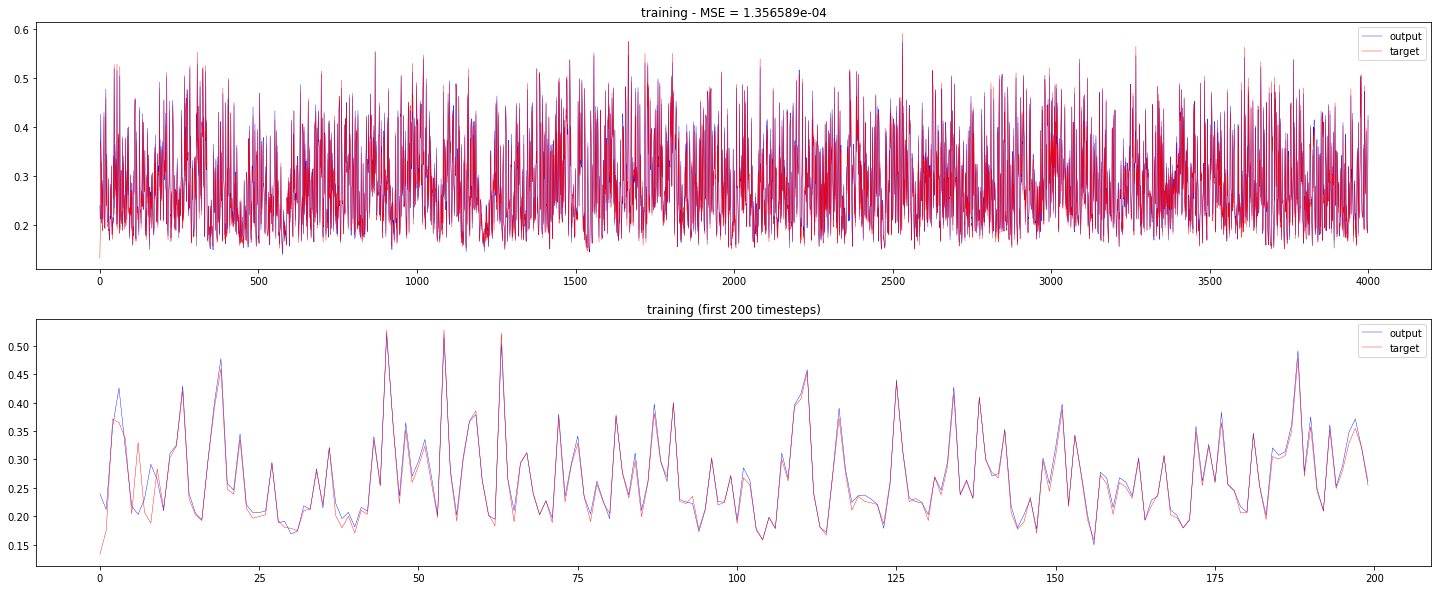

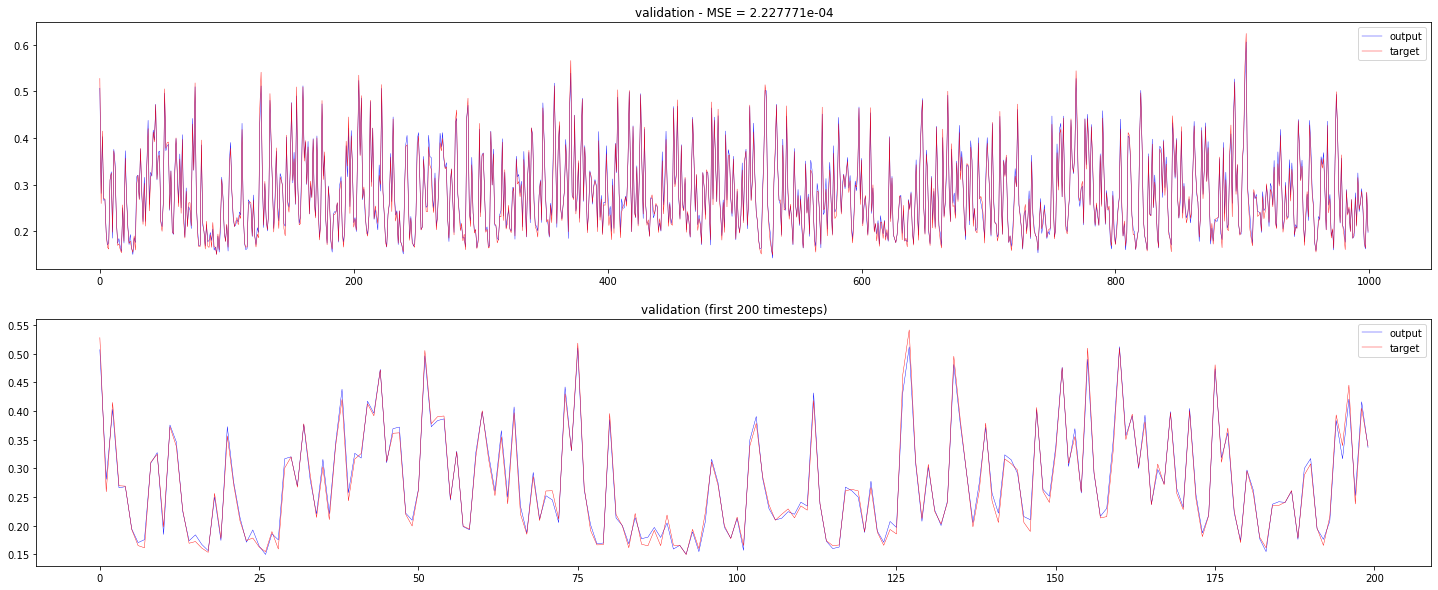

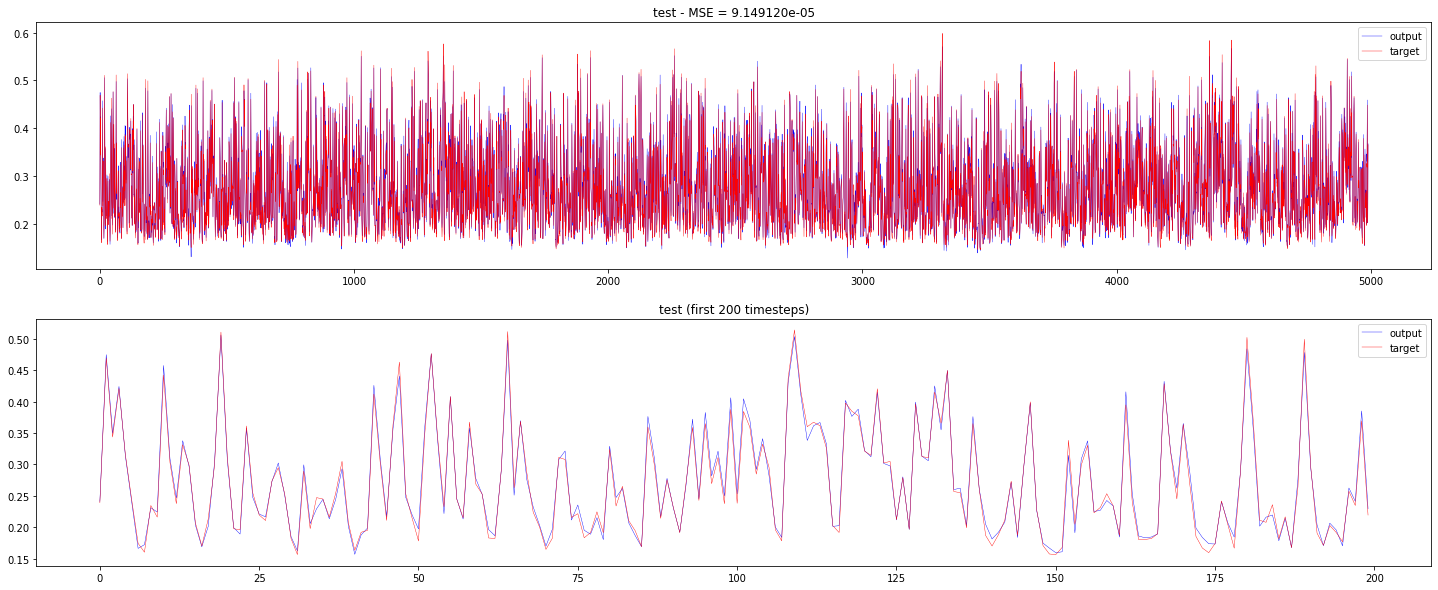

In [28]:
#training
y = hypermodel.predict(X_train)
mse = hypermodel.evaluate(X_train, Y_train)[0]
t=np.arange(start=0,stop=len(X_train[0]), step=1)
plt.figure(figsize = (25,10))
plt.subplot(211)
plt.title(f'training - MSE = {mse:e}')
plt.plot(t,y.ravel(), color = 'b', linewidth= 0.4, label = 'output')
plt.plot(t,Y_train.ravel(), color = 'r', linewidth= 0.4, label = 'target')
plt.legend()

plt.subplot(212)
plt.title('training (first 200 timesteps)')
plt.plot(t[:200],y.ravel()[:200], color = 'b', linewidth= 0.4, label = 'output')
plt.plot(t[:200],Y_train.ravel()[:200], color = 'r', linewidth= 0.4, label = 'target')
plt.legend()

#validation
y = hypermodel.predict(X_valid)
mse = hypermodel.evaluate(X_valid, Y_valid)[0]
t=np.arange(start=0,stop=len(X_valid[0]), step=1)
plt.figure(figsize = (25,10))
plt.subplot(211)
plt.title(f'validation - MSE = {mse:e}')
plt.plot(t,y.ravel(), color = 'b', linewidth= 0.4, label = 'output')
plt.plot(t,Y_valid.ravel(), color = 'r', linewidth= 0.4, label = 'target')
plt.legend()

plt.subplot(212)
plt.title('validation (first 200 timesteps)')
plt.plot(t[:200],y.ravel()[:200], color = 'b', linewidth= 0.4, label = 'output')
plt.plot(t[:200],Y_valid.ravel()[:200], color = 'r', linewidth= 0.4, label = 'target')
plt.legend()

#test
y = hypermodel.predict(X_test)
mse = hypermodel.evaluate(X_test, Y_test)[0]
t=np.arange(start=0,stop=len(Y_test[0]), step=1)
plt.figure(figsize = (25,10))
plt.subplot(211)
plt.title(f'test - MSE = {mse:e}')
plt.plot(t,y.ravel(), color = 'b', linewidth= 0.4, label = 'output')
plt.plot(t,Y_test.ravel(), color = 'r', linewidth= 0.4, label = 'target')
plt.legend()

plt.subplot(212)
plt.title('test (first 200 timesteps)')
plt.plot(t[:200],y.ravel()[:200], color = 'b', linewidth= 0.4, label = 'output')
plt.plot(t[:200],Y_test.ravel()[:200], color = 'r', linewidth= 0.4, label = 'target')
plt.legend()
